# Time Series task
Predict the sales for the next 10 days for each product in each city.

## 1- Importing liberaries

In [39]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")
sns.cubehelix_palette(as_cmap=True)
import matplotlib.pyplot as plt
%matplotlib inline
import holidays
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import IPython
import warnings
warnings.filterwarnings('ignore')

## 2- Data Cleaning



In [2]:
# Reading the data
df=pd.read_csv("/content/drive/MyDrive/datasets/projectdata.xlsx - sheet 1.csv")
# First 5 rows of the data
df.head()

,quantity,UnitePrice,discount,date,retail price,product_name,area,city
0,33,16.0,20.0,2021-10-29T03:33:52Z,16.0,product y,Bahary,North
1,30,16.0,20.0,2021-10-23T12:29:27Z,16.0,product y,Dar El-Salam,Cairo
2,2,45.0,30.0,2021-08-03T09:14:16Z,45.0,product z,Miamy,North
3,3,16.0,3.0,2021-08-17T09:00:50Z,16.0,product y,Miamy,North
4,1,45.0,27.0,2021-09-06T19:57:02Z,45.0,product z,Miamy,North


In [3]:
# Last 5 rows in the data
df.tail()

,quantity,UnitePrice,discount,date,retail price,product_name,area,city
2990,2,99.0,33.0,2022-12-05T09:48:42Z,99.0,product x,Dokki and Mohandessin,Giza
2991,2,99.0,33.0,2022-12-21T00:00:28Z,99.0,product x,Dokki and Mohandessin,Giza
2992,5,45.0,31.0,2022-12-27T08:43:38Z,45.0,product z,Dokki and Mohandessin,Giza
2993,1,99.0,32.0,2022-11-26T09:16:45Z,0.0,product x,El-Agamy,North
2994,2,99.0,33.0,2023-01-06T22:35:26Z,0.0,product x,El-Agamy,North


In [4]:
# Shape of the data (rows,columns)
df.shape

(2995, 8)

In [5]:
# Info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2995 non-null   int64  
 1   UnitePrice    2995 non-null   float64
 2   discount      2995 non-null   float64
 3   date          2995 non-null   object 
 4   retail price  2995 non-null   float64
 5   product_name  2995 non-null   object 
 6   area          2970 non-null   object 
 7   city          2995 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 187.3+ KB


In [6]:
# Statistics about the numerical data
df.describe()

,quantity,UnitePrice,discount,retail price
count,2995.000000,2995.000000,2995.000000,2995.000000
mean,7.705509,60.555426,25.917225,59.615776
std,100.466019,35.270286,14.124298,36.944778
min,1.000000,10.000000,-1.000000,0.000000
25%,2.000000,16.000000,20.000000,16.000000
50%,3.000000,45.000000,31.000000,45.000000
75%,5.000000,99.000000,33.000000,99.000000
max,5000.000000,102.000000,561.000000,102.000000


In [7]:
# Create a new 'sales' column
df['sales'] = df['quantity'] * df['UnitePrice']

In [8]:
# check for null values in the data
df.isnull().sum()

,0
quantity,0
UnitePrice,0
discount,0
date,0
retail price,0
product_name,0
area,25
city,0
sales,0


Noticed that 'area' column has 25 null values

In [9]:
# fill null values in 'area' with 'unknown'
df['area']=df['area'].fillna('unknown')
# check that the null values are filled
print("\nNull Values After Filling:")
df.isnull().sum()


Null Values After Filling:


,0
quantity,0
UnitePrice,0
discount,0
date,0
retail price,0
product_name,0
area,0
city,0
sales,0


####**The data now is clean** with no null values.

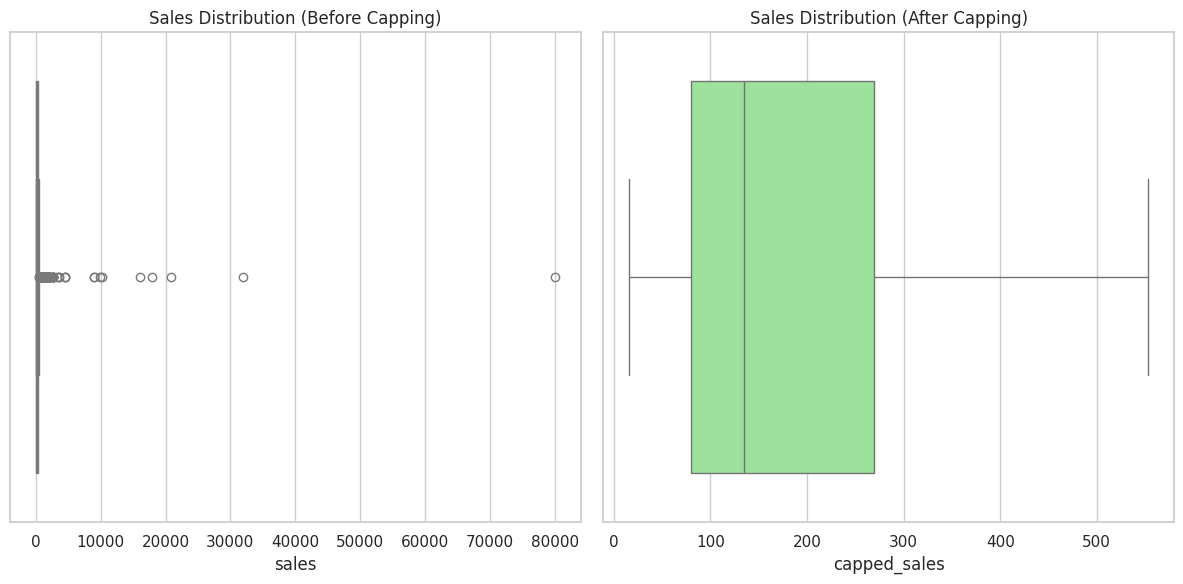

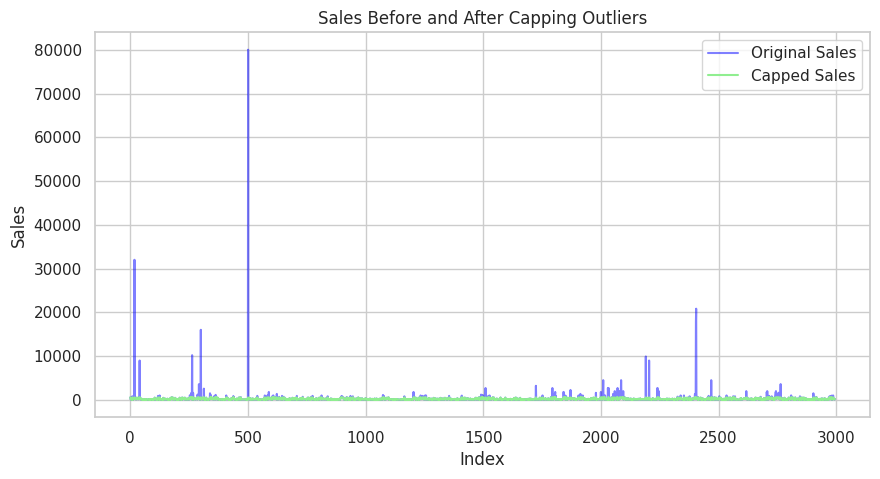

In [10]:
# IQR method to detect outliers
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1

# Defining lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a copy of sales data for capping
capped_sales = df['sales'].copy()

# Capping outliers
capped_sales = np.where(capped_sales > upper_bound, upper_bound, capped_sales)
capped_sales = np.where(capped_sales < lower_bound, lower_bound, capped_sales)

# Adding the capped sales to the DataFrame for comparison
df['capped_sales'] = capped_sales

# Visualizing before and after capping using boxplots
plt.figure(figsize=(12, 6))

# Boxplot before capping
plt.subplot(1, 2, 1)
sns.boxplot(x=df['sales'], color='lightblue')  # Change boxplot color
plt.title('Sales Distribution (Before Capping)')

# Boxplot after capping
plt.subplot(1, 2, 2)
sns.boxplot(x=df['capped_sales'], color='lightgreen')  # Change boxplot color
plt.title('Sales Distribution (After Capping)')

plt.tight_layout()
plt.show()

# Visualize the cleaned sales data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['sales'], label='Original Sales', alpha=0.5, color='blue')  # Change line color
plt.plot(df.index, df['capped_sales'], label='Capped Sales', color='lightgreen')  # Keep the capped sales color
plt.title('Sales Before and After Capping Outliers')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.show()


## 3- EDA(exploratory data analysis)

In [11]:
# Unique values in 'city' and 'product' columns
print("city values:", df['city'].unique())
print("product values:" , df['product_name'].unique())

city values: ['North' 'Cairo' 'Giza']
product values: ['product y' 'product z' 'product x ']


In [12]:
# Ensure that the date in in datetime format
df['date']=pd.to_datetime(df['date'])

In [13]:
# Sort the data in each city by date
df=df.sort_values(by=['date']).reset_index(drop=True)
df.head()

,quantity,UnitePrice,discount,date,retail price,product_name,area,city,sales,capped_sales
0,5,102.0,33.0,2021-03-31 11:38:58+00:00,102.0,product x,El-Mokattam,Cairo,510.0,510.0
1,1,16.0,9.0,2021-04-30 20:56:54+00:00,16.0,product y,Ain Shams,Cairo,16.0,16.0
2,10,16.0,9.0,2021-05-08 14:12:52+00:00,16.0,product y,El-Zaitoun,Cairo,160.0,160.0
3,10,45.0,22.0,2021-05-08 14:12:52+00:00,45.0,product z,El-Zaitoun,Cairo,450.0,450.0
4,10,16.0,20.0,2021-05-22 10:56:31+00:00,16.0,product y,Bakos,North,160.0,160.0


In [14]:
df.tail()

,quantity,UnitePrice,discount,date,retail price,product_name,area,city,sales,capped_sales
2990,2,99.0,27.0,2023-01-17 01:33:40+00:00,99.0,product x,Moharam Bek,North,198.0,198.0
2991,5,99.0,28.0,2023-01-17 07:51:04+00:00,99.0,product x,Fleming,North,495.0,495.0
2992,2,99.0,27.0,2023-01-17 07:51:06+00:00,99.0,product x,Fleming,North,198.0,198.0
2993,1,99.0,27.0,2023-01-17 08:13:12+00:00,99.0,product x,El-Ibrahimia,North,99.0,99.0
2994,3,99.0,29.0,2023-01-17 09:24:09+00:00,99.0,product x,Faisal,Giza,297.0,297.0


In [15]:
# group the data by 'city' and 'date' to calculate total sales per day in each city
city_sales_by_date= df.groupby(['city','date']).agg({'sales':'sum'}).reset_index()

# group the data by 'city' and 'sales' to calculate city with most sales
city_total_sales= df.groupby(['city']).agg({'sales':'sum'}).reset_index()

# group the data by 'city' and 'quantity' to calculate city with most qantities
city_sales_by_quantity= df.groupby(['city']).agg({'quantity':'sum'}).reset_index()

# group data bt 'city' and 'product' to calculate total sales and quantities for each product in each city
city_sales_by_product= df.groupby(['city','product_name']).agg({'sales':'sum'}).reset_index()
city_quantity_by_product= df.groupby(['city','product_name']).agg({'quantity':'sum'}).reset_index()

# Create a new column for the day of the week
city_sales_by_date['Day_of_Week'] = city_sales_by_date['date'].dt.dayofweek

# Group by Day of the Week and City, summing the sales
sales_by_day_and_city = city_sales_by_date.groupby(['Day_of_Week', 'city'])['sales'].sum().reset_index()

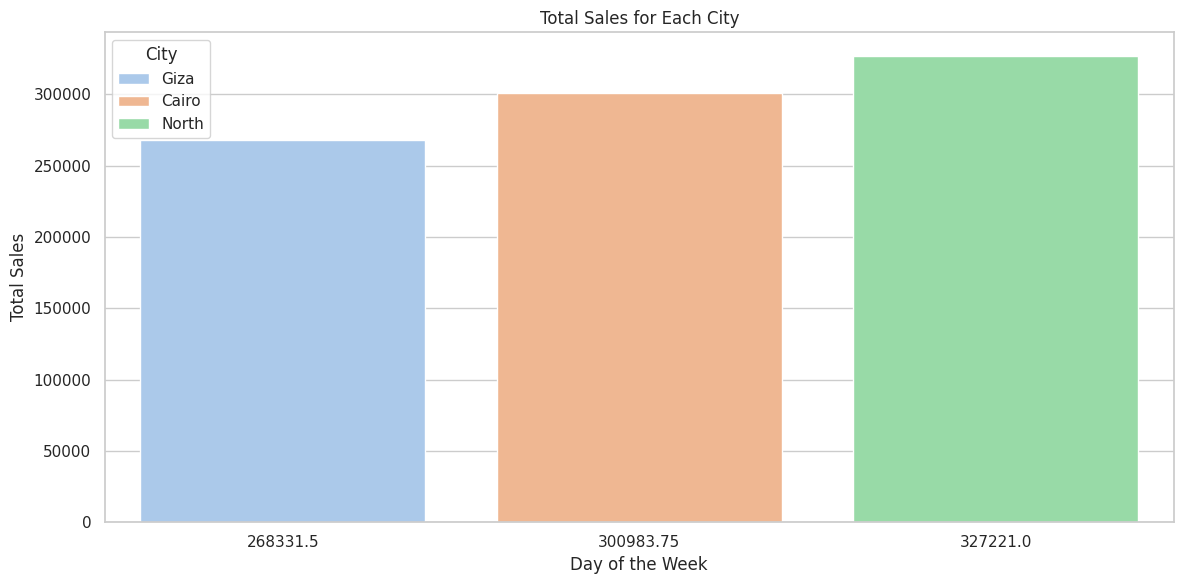

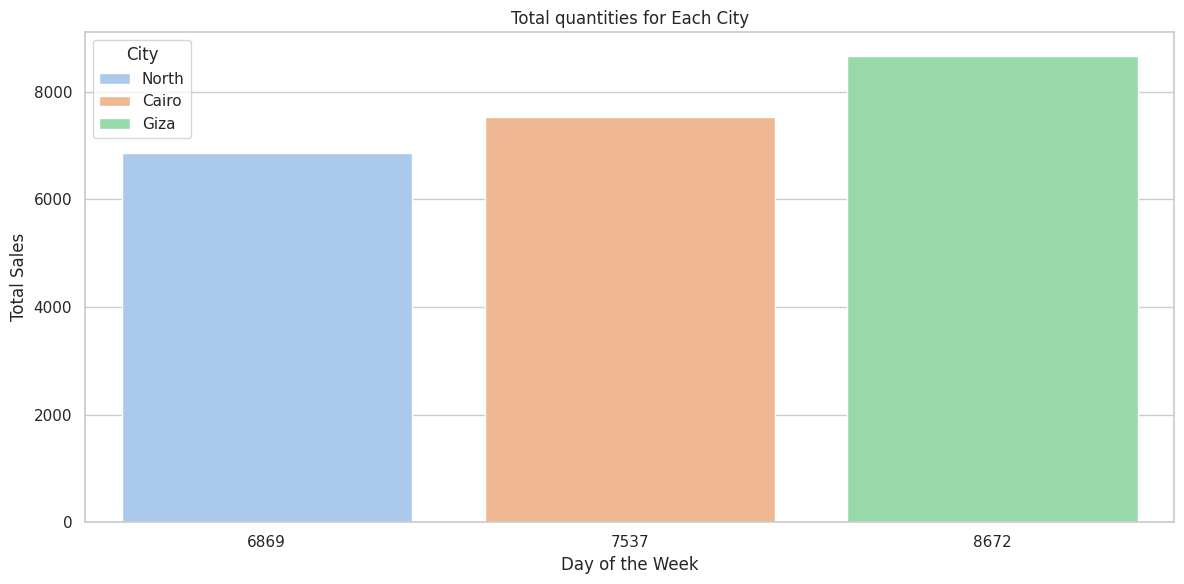

In [16]:

# Plot total sales for each city
plt.figure(figsize=(12, 6))
sns.barplot(x='sales', y='sales', hue='city', data=city_total_sales ,palette="pastel")
plt.title('Total Sales for Each City')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.legend(title='City')
plt.tight_layout()
plt.show()

# Plot total quantity for each city
plt.figure(figsize=(12, 6))
sns.barplot(x='quantity', y='quantity', hue='city', data=city_sales_by_quantity,palette="pastel")
plt.title('Total quantities for Each City')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.legend(title='City')
plt.tight_layout()
plt.show()

### **Insights**:
* Giza is the city with most sales with total 315321,25.
* North is the city with least sales with total 275824.
* Giza is the city with most sales with total 8672.
* North is the city with least sales with total 6869.
#### that means that even that Giza has the most quantities sold it is sold with less values than North.

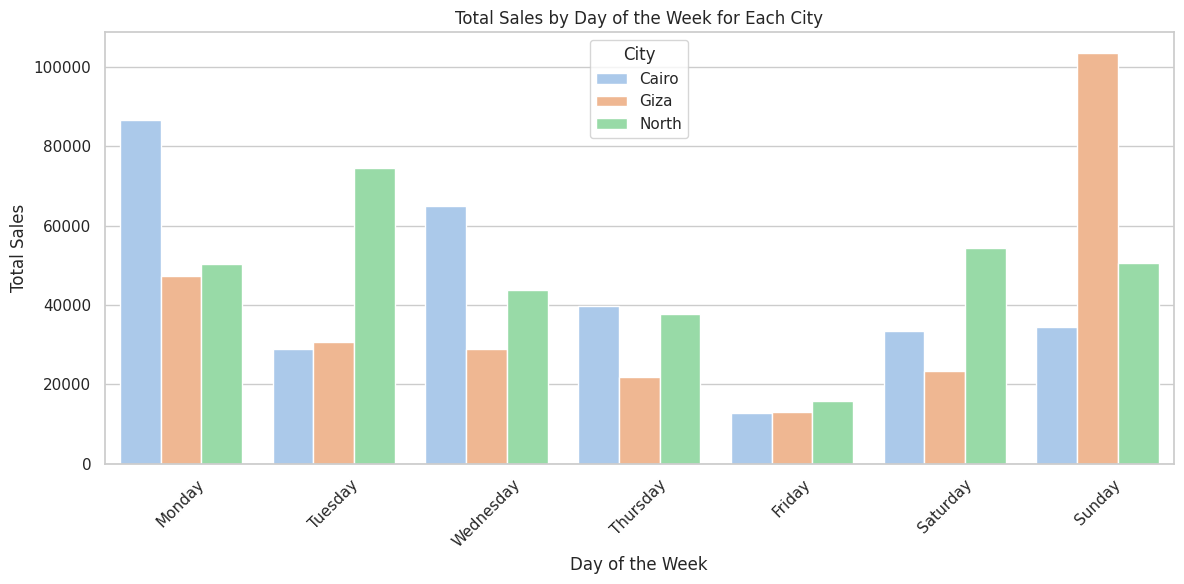

In [17]:

# Plot total sales by day of the week for each city
plt.figure(figsize=(12, 6))
ax=sns.barplot(x='Day_of_Week', y='sales', hue='city', data=sales_by_day_and_city,palette="pastel")
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.title('Total Sales by Day of the Week for Each City')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.legend(title='City')
plt.tight_layout()
plt.show()

###**Insights:**

*  Giza is the city with the most sales on Sunday.
* Cairo is the city with most sales on Monday and Thursday.
* North is the city with most sales on Tuesday and Saturday.
* The total sales are less on the weekends than on the weekdays.

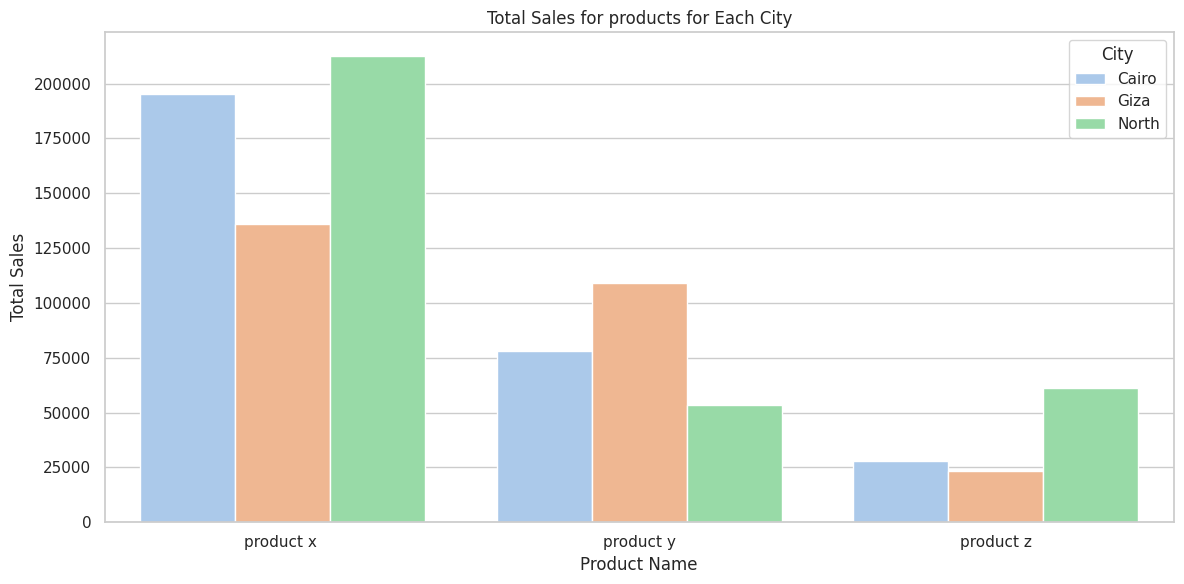

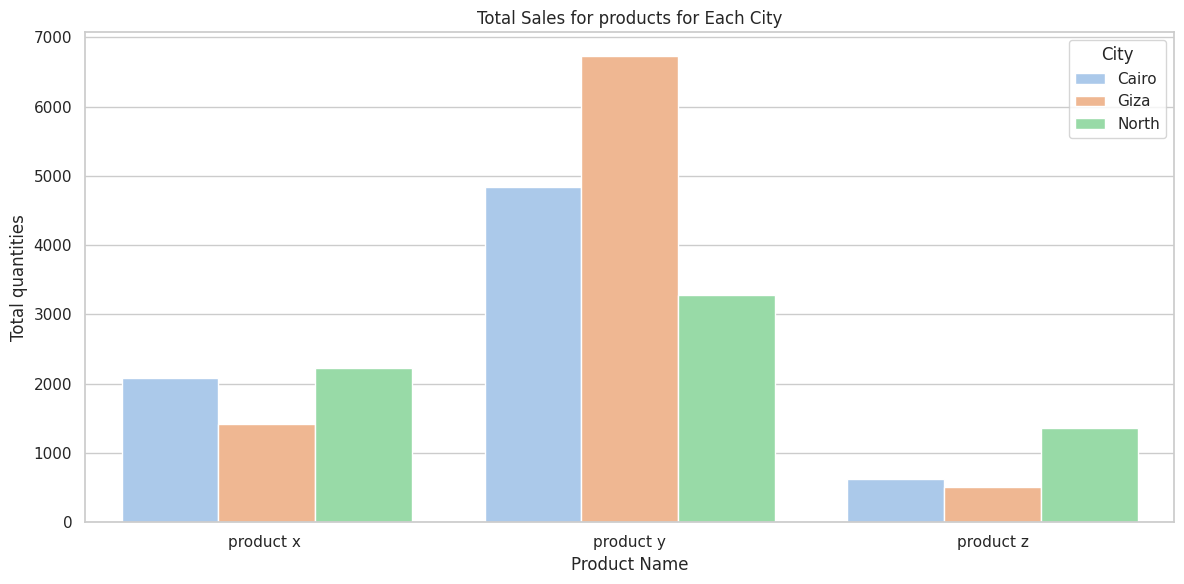

In [18]:

# Plot total sales by each product for each city
plt.figure(figsize=(12, 6))
sns.barplot(x='product_name', y='sales', hue='city', data=city_sales_by_product,palette="pastel")
plt.title('Total Sales for products for Each City')
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.legend(title='City')
plt.tight_layout()
plt.show()


# Plot total sales by each product for each city
plt.figure(figsize=(12, 6))
sns.barplot(x='product_name', y='quantity', hue='city', data=city_quantity_by_product)
plt.title('Total Sales for products for Each City')
plt.xlabel('Product Name')
plt.ylabel('Total quantities')
plt.legend(title='City')
plt.tight_layout()
plt.show()

###**Insights:**
* Product y is the most sold product in all cities.
* Product z is the least sold product.
* Product x is sold with more money
####that  means that *Product* x is more expensive than product y but it is less brought.




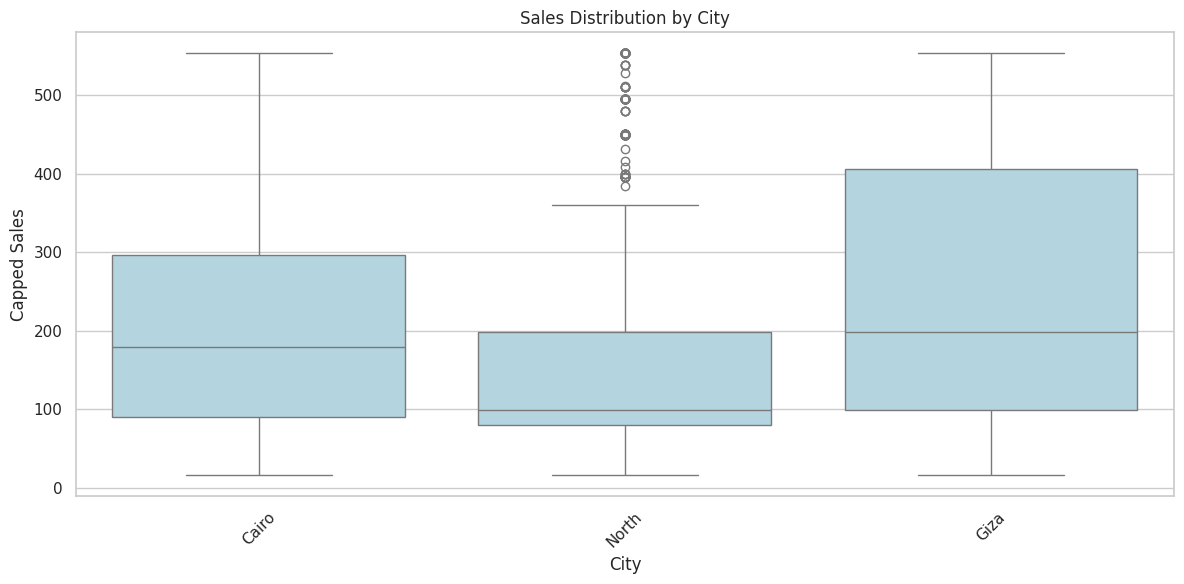

In [19]:
# Boxplot for sales distribution by city
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='capped_sales', data=df,color='lightblue')
plt.title('Sales Distribution by City')
plt.xlabel('City')
plt.ylabel('Capped Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

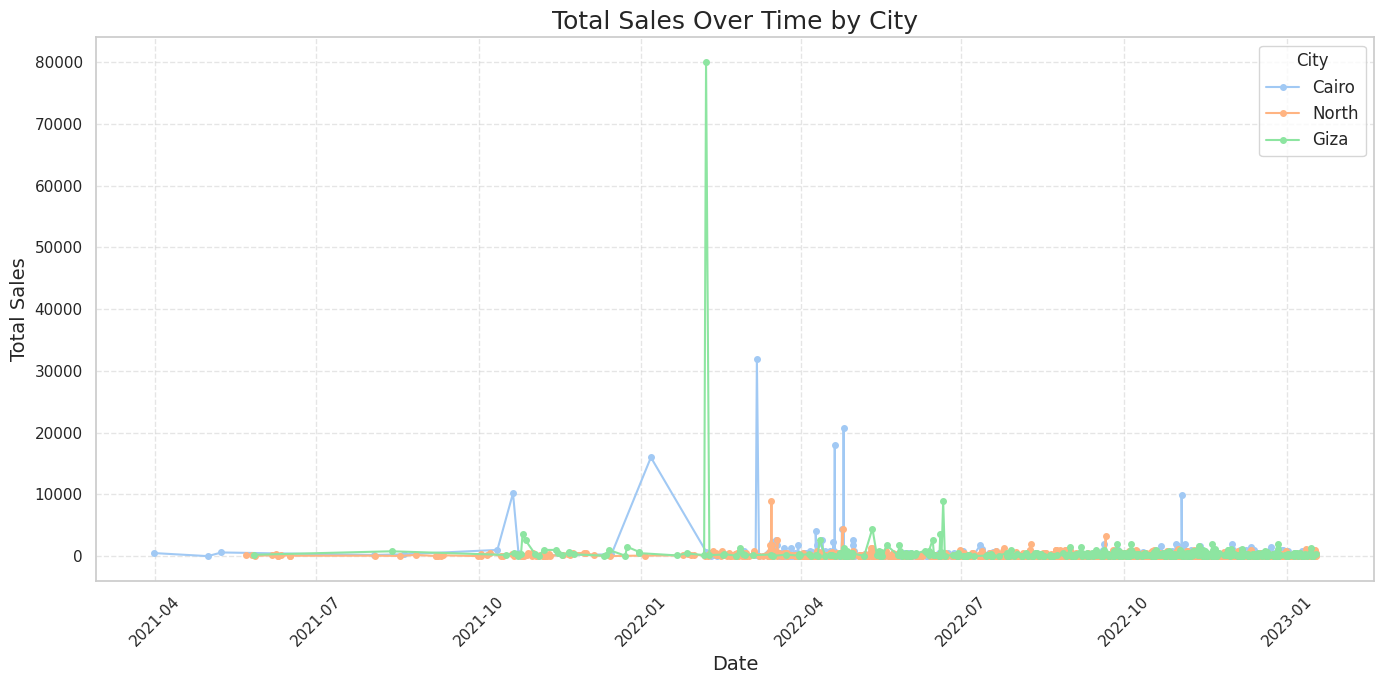

In [20]:
# Sales Over Time Plot by each City
plt.figure(figsize=(14, 7))
for city in df['city'].unique():
    city_data = city_sales_by_date[city_sales_by_date['city'] == city]
    plt.plot(city_data['date'], city_data['sales'], label=city, marker='o', markersize=4)

plt.title('Total Sales Over Time by City', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='City', fontsize=12)
plt.tight_layout()
plt.show()


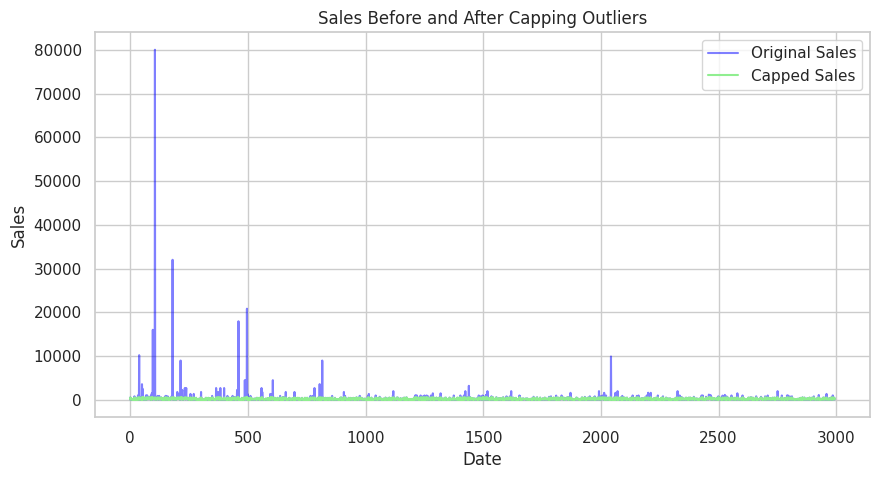

In [21]:
# Visualize the cleaned sales data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['sales'], label='Original Sales', alpha=0.5, color='blue')
plt.plot(df.index, df['capped_sales'], label='Capped Sales', color='lightgreen')
plt.title('Sales Before and After Capping Outliers')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 4- Feature Engineering

In [22]:
# Create a new feature to identify if the date is a holiday
egypt_holidays = holidays.Egypt()
df['is_holiday'] = df['date'].apply(lambda x: 1 if x in egypt_holidays else 0)

In [23]:
# Set 'date' as index for time series analysis
df.set_index('date', inplace=True)
df.head()

,quantity,UnitePrice,discount,retail price,product_name,area,city,sales,capped_sales,is_holiday
date,,,,,,,,,,
2021-03-31 11:38:58+00:00,5,102.0,33.0,102.0,product x,El-Mokattam,Cairo,510.0,510.0,0
2021-04-30 20:56:54+00:00,1,16.0,9.0,16.0,product y,Ain Shams,Cairo,16.0,16.0,0
2021-05-08 14:12:52+00:00,10,16.0,9.0,16.0,product y,El-Zaitoun,Cairo,160.0,160.0,0
2021-05-08 14:12:52+00:00,10,45.0,22.0,45.0,product z,El-Zaitoun,Cairo,450.0,450.0,0
2021-05-22 10:56:31+00:00,10,16.0,20.0,16.0,product y,Bakos,North,160.0,160.0,0


In [24]:
# Create time series features
def create_features(data):
    data['hour'] = data.index.hour
    data['day'] = data.index.dayofweek
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['day_of_month'] = data.index.day
    data['day_of_year'] = data.index.dayofyear
    data['week_of_year'] = data.index.isocalendar().week
    return data

# Apply the feature creation function
df = create_features(df)

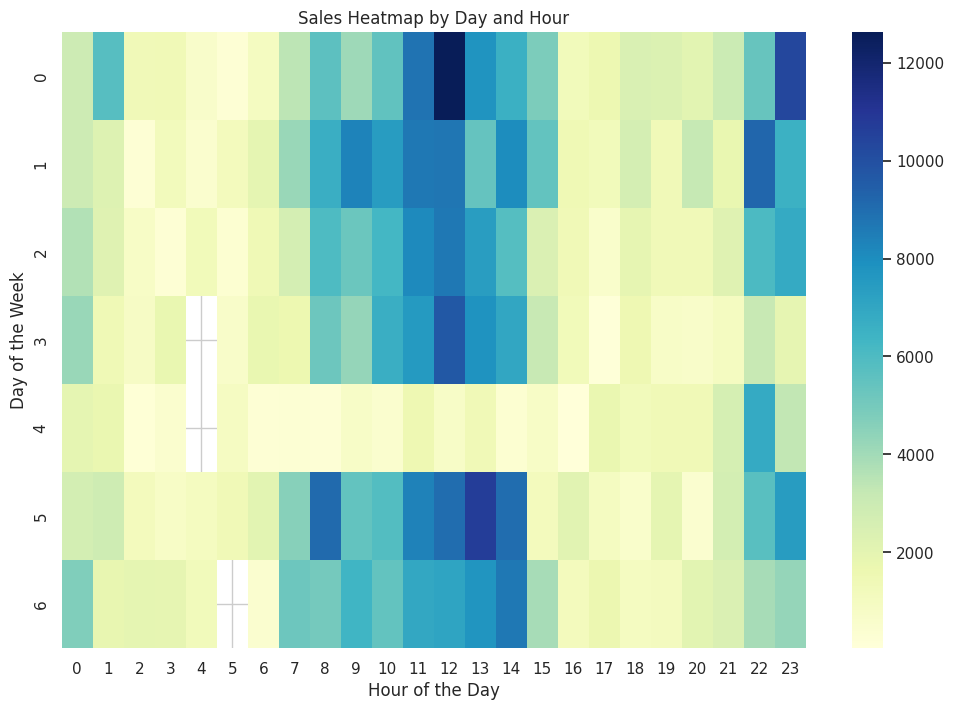

In [25]:
pivot = df.pivot_table(values='capped_sales', index='day', columns='hour', aggfunc='sum')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Sales Heatmap by Day and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()


In [26]:
# Creating lag features for previous sales
df['lag_1'] = df.groupby(['city', 'product_name'])['capped_sales'].shift(7)
df['lag_2'] = df.groupby(['city', 'product_name'])['capped_sales'].shift(30)
# drop missing lag features
df.dropna(inplace=True)

In [27]:
# Rolling features
df['rolling_mean_7'] = df['capped_sales'].rolling(window=7).mean()
df['rolling_std_7'] = df['capped_sales'].rolling(window=7).std()

In [28]:
# Group data by 'city', 'product_name', and 'date', and aggregate the sales for each combination
data = df.groupby(['city', 'product_name', 'quantity','date','discount','retail price','is_holiday',
                   'hour', 'day', 'month', 'year', 'day_of_month', 'day_of_year', 'week_of_year',
                   'lag_1', 'lag_2', 'rolling_mean_7' ,'rolling_std_7']).agg({'capped_sales': 'sum'}).reset_index()

# Sort by city, product, and date for proper time series alignment
data = data.sort_values(by=['city', 'product_name', 'date'])

data.head()

,city,product_name,quantity,date,discount,retail price,is_holiday,hour,day,month,year,day_of_month,day_of_year,week_of_year,lag_1,lag_2,rolling_mean_7,rolling_std_7,capped_sales
176,Cairo,product x,3,2022-03-26 21:15:18+00:00,31.0,99.0,0,21,5,3,2022,26,85,12,448.750,510.000,256.607143,96.364635,269.25
177,Cairo,product x,3,2022-03-27 13:38:48+00:00,32.0,99.0,0,13,6,3,2022,27,86,12,89.750,204.000,230.785714,47.973393,269.25
85,Cairo,product x,2,2022-03-27 14:34:00+00:00,32.0,99.0,0,14,6,3,2022,27,86,12,448.750,306.000,217.964286,47.973393,179.50
178,Cairo,product x,3,2022-03-28 01:41:53+00:00,32.0,99.0,0,1,0,3,2022,28,87,13,89.750,553.125,217.964286,47.973393,269.25
0,Cairo,product x,1,2022-03-28 14:52:49+00:00,32.0,99.0,0,14,0,3,2022,28,87,13,553.125,553.125,205.142857,67.844623,89.75


## 5- Time Series Modeling

In [29]:
# Scale numerical features
numerical_cols = ['discount', 'retail price', 'week_of_year',
                  'lag_1', 'lag_2', 'rolling_mean_7', 'rolling_std_7']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

data.head()

,city,product_name,quantity,date,discount,retail price,is_holiday,hour,day,month,year,day_of_month,day_of_year,week_of_year,lag_1,lag_2,rolling_mean_7,rolling_std_7,capped_sales
176,Cairo,product x,3,2022-03-26 21:15:18+00:00,0.329727,1.040677,0,21,5,3,2022,26,85,-1.513774,1.660516,2.014191,1.013039,-0.865161,269.25
177,Cairo,product x,3,2022-03-27 13:38:48+00:00,0.399781,1.040677,0,13,6,3,2022,27,86,-1.513774,-0.642929,0.074917,0.617222,-1.764183,269.25
85,Cairo,product x,2,2022-03-27 14:34:00+00:00,0.399781,1.040677,0,14,6,3,2022,27,86,-1.513774,1.660516,0.721342,0.420681,-1.764183,179.50
178,Cairo,product x,3,2022-03-28 01:41:53+00:00,0.399781,1.040677,0,1,0,3,2022,28,87,-1.443328,-0.642929,2.287496,0.420681,-1.764183,269.25
0,Cairo,product x,1,2022-03-28 14:52:49+00:00,0.399781,1.040677,0,14,0,3,2022,28,87,-1.443328,2.330215,2.287496,0.224141,-1.395011,89.75


In [30]:
# Convert categorical columns to category type
categorical_cols = ['city', 'product_name']
for col in categorical_cols:
    data[col] = data[col].astype('category')
# Set date as index for time series analysis
data.set_index('date', inplace=True)
data.head()

,city,product_name,quantity,discount,retail price,is_holiday,hour,day,month,year,day_of_month,day_of_year,week_of_year,lag_1,lag_2,rolling_mean_7,rolling_std_7,capped_sales
date,,,,,,,,,,,,,,,,,,
2022-03-26 21:15:18+00:00,Cairo,product x,3,0.329727,1.040677,0,21,5,3,2022,26,85,-1.513774,1.660516,2.014191,1.013039,-0.865161,269.25
2022-03-27 13:38:48+00:00,Cairo,product x,3,0.399781,1.040677,0,13,6,3,2022,27,86,-1.513774,-0.642929,0.074917,0.617222,-1.764183,269.25
2022-03-27 14:34:00+00:00,Cairo,product x,2,0.399781,1.040677,0,14,6,3,2022,27,86,-1.513774,1.660516,0.721342,0.420681,-1.764183,179.50
2022-03-28 01:41:53+00:00,Cairo,product x,3,0.399781,1.040677,0,1,0,3,2022,28,87,-1.443328,-0.642929,2.287496,0.420681,-1.764183,269.25
2022-03-28 14:52:49+00:00,Cairo,product x,1,0.399781,1.040677,0,14,0,3,2022,28,87,-1.443328,2.330215,2.287496,0.224141,-1.395011,89.75


### 1. Data Split

In [31]:
# Create features and target values
X = data.drop('capped_sales', axis=1)
y = data['capped_sales']

In [32]:
# Used Stratified Split
train_data, test_data, train_target, test_target = train_test_split(
    X, y, test_size=0.2, stratify=data['city'], random_state=42)

### 2. Model Training and Prediction using LightGBM

In [33]:
# Prepare LightGBM datasets
train_ds = lgb.Dataset(train_data, label=train_target, categorical_feature=categorical_cols)
test_ds = lgb.Dataset(test_data, label=test_target, reference=train_ds)


In [34]:
# Set up LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators':100,
    'learning_rate': 0.1,
    'num_leaves': 11,
    'max_depth': 5,
    'verbose': -1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_data_in_leaf': 50

}

# Train the model
model = lgb.train(params, train_ds, valid_sets=[test_ds], num_boost_round=100)

# Make predictions
predictions = model.predict(test_data[X.columns])

In [35]:
# Make predictions on the test set
predictions = model.predict(test_data)


### 3. Model Evaluation

In [36]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test_target, predictions))
mae = mean_absolute_error(test_target, predictions)
mse = mean_squared_error(test_target, predictions)
mape = np.mean(np.abs((test_target - predictions) / test_target)) * 100
mpe = np.mean((test_target - predictions) / test_target)

r2 = r2_score(test_target, predictions)

# Print the evaluation metrics results
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")
print(f"MPE: {mpe}")
print(f"R²: {r2}")

RMSE: 8.58600689500772
MAE: 3.886271220519211
MSE: 73.71951440112012
MAPE: 2.036967130705419
MPE: -0.002136617420404802
R²: 0.9970434095841175


### 4. Visualization of Results

In [37]:
# Prepare results DataFrame
predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=['Predicted Sales'])
results_df = pd.concat([test_target.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1)
results_df.columns = ['Actual Sales', 'Predicted Sales']

In [40]:
# Prepare DataFrame for actual and predicted values by city and product
results_df = test_data.copy()
results_df['Actual Sales'] = test_target
results_df['Predicted Sales'] = predictions
results_df['city'] = test_data['city']
results_df['product_name'] = test_data['product_name']
# Sort the pridictions by 'city','product name' and 'date'

results_df.sort_values(by=['city', 'product_name','date'], inplace=True)

# Display the final DataFrame
IPython.display.display(results_df[['city', 'product_name', 'Actual Sales', 'Predicted Sales']])

,city,product_name,Actual Sales,Predicted Sales
date,,,,
2022-03-27 13:38:48+00:00,Cairo,product x,269.25,269.874889
2022-03-28 14:52:49+00:00,Cairo,product x,89.75,89.180340
2022-04-02 23:48:16+00:00,Cairo,product x,448.75,453.724214
2022-04-03 00:51:49+00:00,Cairo,product x,89.75,89.161236
2022-04-06 12:41:28+00:00,Cairo,product x,269.25,270.640130
...,...,...,...,...
2023-01-05 12:36:12+00:00,North,product z,90.00,92.428253
2023-01-08 00:11:06+00:00,North,product z,90.00,91.486092
2023-01-08 22:49:03+00:00,North,product z,90.00,91.505081


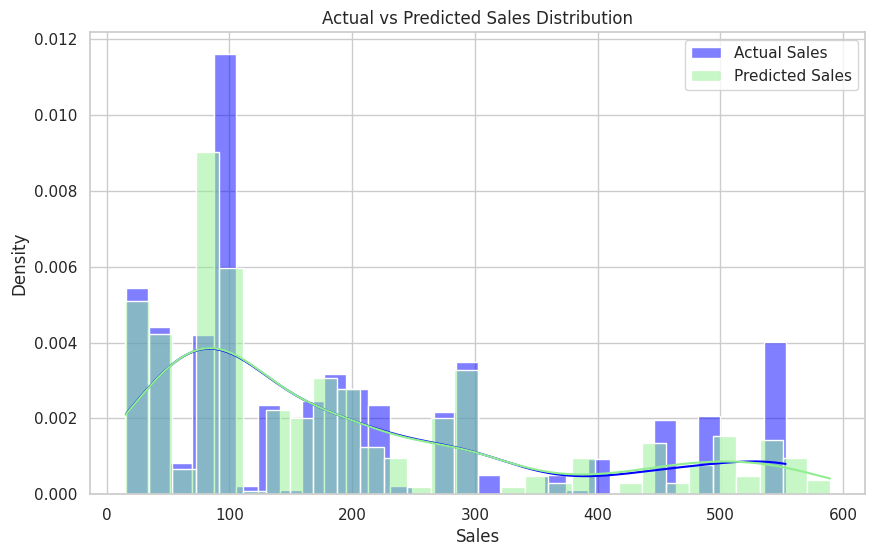

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(test_target, color='blue', label='Actual Sales', kde=True, stat='density', bins=30)
sns.histplot(predictions, color='lightgreen', label='Predicted Sales', kde=True, stat='density', bins=30)
plt.xlabel('Sales')
plt.ylabel('Density')
plt.title('Actual vs Predicted Sales Distribution')
plt.legend()
plt.show()


### Noticed that:
* Busiest Days: Sunday and Saturday appear to be the busiest days overall, with consistently high sales throughout most hours.
* Quietest Days:  Wednesday and Thursday seem to be the quietest days, with lower sales volumes compared to other days.
* The peak sales hours are generally between 12 PM and 8 PM, with a slight increase in sales around 6 PM
* The off-peak hours are typically between 1 AM and 5 AM, with minimal sales activity.

In [45]:
# Get the last 10 days for each city and product
last_10_days_df = results_df.groupby(['city', 'product_name']).tail(10)

# Sort the DataFrame by date index (which is already set as index)
last_10_days_df_sorted = last_10_days_df.sort_index()

# Display tables for each city
for city in last_10_days_df_sorted['city'].unique():
    city_data = last_10_days_df_sorted[last_10_days_df_sorted['city'] == city]
    print(f"City: {city}")
    display(city_data[['product_name', 'Actual Sales', 'Predicted Sales']])

City: Cairo


,product_name,Actual Sales,Predicted Sales
date,,,
2022-09-26 19:28:30+00:00,product z,225.000,232.900986
2022-09-28 12:08:39+00:00,product z,135.000,138.842390
2022-10-05 09:36:57+00:00,product z,45.000,45.141293
2022-10-15 13:46:42+00:00,product z,135.000,138.816710
2022-11-02 15:35:09+00:00,product z,90.000,90.417090
2022-11-12 19:18:16+00:00,product y,80.000,82.885489
2022-11-15 09:51:10+00:00,product y,64.000,62.706182
2022-11-16 04:32:11+00:00,product z,225.000,221.083855
2022-11-22 13:14:05+00:00,product y,80.000,82.396132


City: Giza


,product_name,Actual Sales,Predicted Sales
date,,,
2022-11-17 19:56:28+00:00,product z,225.000,222.718492
2022-11-19 23:10:25+00:00,product z,135.000,134.957659
2022-11-21 01:48:52+00:00,product z,450.000,448.696095
2022-12-04 22:30:29+00:00,product y,144.000,160.404451
2022-12-06 10:17:31+00:00,product z,553.125,512.370259
2022-12-07 10:35:12+00:00,product y,16.000,17.794135
2022-12-08 08:39:43+00:00,product y,320.000,345.774969
2022-12-10 12:19:01+00:00,product z,225.000,221.038127
2022-12-12 22:57:23+00:00,product z,225.000,221.899916


City: North


,product_name,Actual Sales,Predicted Sales
date,,,
2022-12-05 08:10:47+00:00,product y,32.0,32.339175
2022-12-06 20:55:24+00:00,product y,64.0,64.427495
2022-12-13 22:43:30+00:00,product y,160.0,165.514071
2022-12-16 15:58:10+00:00,product y,48.0,51.109494
2022-12-18 12:56:47+00:00,product y,32.0,33.509188
2022-12-19 00:08:03+00:00,product y,16.0,19.271194
2022-12-20 08:50:40+00:00,product y,132.0,106.493974
2022-12-28 14:21:32+00:00,product z,45.0,45.272125
2023-01-01 07:39:23+00:00,product z,90.0,89.673509


## 6- Conclusion

**In this project**, we aimed to predict the sales for the next 10 days for each product across various cities, utilizing a comprehensive approach that included data cleaning, exploratory data analysis (EDA), feature engineering, and model evaluation. Throughout the analysis, we identified key insights related to sales trends by city and day of the week, allowing us to understand the underlying patterns in the data.
One critical insight gained during the project was the realization that the initial year of sales data may not have been of high quality, potentially affecting the model's predictive accuracy. This finding highlights the importance of evaluating the quality of historical data and its impact on model performance.\
\
**Evaluation metrics** To assess the effectiveness of our predictive model, we employed several regression evaluation metrics:

* Root Mean Square Error (RMSE): 8.59
* Mean Absolute Error (MAE): 3.89
* Mean Squared Error (MSE): 73.72
* Mean Absolute Percentage Error (MAPE): 2.04%
* Mean Percentage Error (MPE): -0.0021%
* R-squared (R²): 0.997 \

These metrics indicate that our model performed exceptionally well, with a high R² value of 0.997, suggesting that the model explains a significant portion of the variance in the sales data. The low RMSE and MAE values further demonstrate the model's accuracy in forecasting sales.
